In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})
import scipy
from utilities import convert2D_to_1D, error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual, matrixA, forward_substitution, backward_substitution

In [8]:
def NZA(A):
    """

    :param A: Banded Matrix A
    :return: Sparsity pattern, if the element is not zero, at the index of that element, NZA[i, j] = 1
    """
    NZA = np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] != 0:
                NZA[i, j] = 1

    return NZA


def ILU0(NZA, AA):
    """

    :param NZA: Sparsity pattern
    :param AA: Banded Matrix A
    :return: Decomposed matrix A --> [L] [U] = [A]
    """
    L = np.eye(NZA.shape[0])
    U = np.zeros(NZA.shape)
    K = NZA.shape[0]

    for k in tqdm(range(K - 1)):
        for i in range(k+1, K):

            if NZA[i, k] == 1:
                AA[i, k] = AA[i, k] / AA[k, k]

            for j in range(k+1, K):
                if NZA[i, j] == 1:
                    AA[i, j] = AA[i, j] + AA[i, k] * AA[k, j]

    for i in range(K):
        for j in range(i, K):
            U[i, j] = AA[i, j]

        for j in range(i):
            L[i, j] = AA[i, j]

    return L, U


def matmul_between_transpose_and_normal(mat1, mat2, N, M):
    """

    :param mat1: the matrix that will be transposed
    :param mat2: normal matrix
    :param N: The number of grid in x-axis
    :param M: The number of grid in y-axis
    :return: A scalar: [mat1].T @ [mat2]
    """
    output = 0
    for i in range(1, N - 1):
        for j in range(1, M - 1):
            k = (j - 1) * N + i
            output = output + mat1[k] * mat2[k]

    return output


def Compute_Rm(L, U, R):
    """
    [ M ] [ Rm ] = [ R ]
    [ M ] = [ L ] [ U ]
    [ L ] [ U ] [ Rm ] = [ R ]
    [ U ] [ Rm ] = [ Y ]
    [ L ] [ Y ] = [ R ]

    # Compute above steps from last eqn to top eqn without using matrix
    """
    Y = backward_substitution(L, R)

    Rm = forward_substitution(U, Y)
    # Y = scipy.sparse.linalg.spsolve_triangular(L, R, lower=True)
    # Rm = scipy.sparse.linalg.spsolve_triangular(U, Y, lower=False)
    # Rm = L@U@R
    return Rm

In [14]:

start = time.time()
Nx = 41
Ny = 41
Length = 1  # length
Height = 1
phi = np.zeros((Nx * Ny))

dx = Length / (Nx - 1)  # Grid size
dy = Height / (Ny - 1)  # Grid size

tol = 1e-6

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

# Same coefficient name as Stone's method
K = Nx * Ny
B = np.full(K, aS)
D = np.full(K, aW)
E = np.full(K, a0)
F = np.full(K, aE)
H = np.full(K, aN)

phi, S = prepare_phi_and_S(Nx, Ny, phi, Length, Height, convert_to_K=True)

A = matrixA(Nx, Ny, dx, dy)
AA = np.copy(A)
nza = NZA(AA)
L, U = ILU0(nza, AA)
# L = convert2D_to_1D(L, Nx, Ny)
# U = convert2D_to_1D(U, Nx, Ny)
# phi, A = scipy.sparse.linalg.cg(A,S) 

100%|██████████| 1680/1680 [03:52<00:00,  7.23it/s] 


In [15]:

# decomposition = scipy.sparse.linalg.spilu(A)
# L = decomposition.L
# U = decomposition.U

# Initial residual
R2_old, Rsum_old, R_old = residual(Nx, Ny, phi, S, aE, aW, aN, aS, a0, convert=True)

# Modified residual Rm
Rm_old = Compute_Rm(L, U, R_old)

# Step 3: Set the initial search direction vector equal to the residual vector
D0 = Rm_old

for _ in tqdm(range(100000)):

    # Compute new alpha
    # Compute A@D
    ad = np.zeros(Nx * Ny)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            k = (j - 1) * Nx + i
            # k = K-1

            ad[k] = E[k] * D0[k] + F[k] * D0[k + 1] + H[k] * D0[k + Nx] + D[k] * D0[k - 1] + B[k] * D0[k - Nx]

    Dt_ad = 0
    for k in range(Nx*Ny):
        Dt_ad = Dt_ad + D0[k] * ad[k]

    alpha_new = Rsum_old / Dt_ad

    phi = phi + alpha_new * D0

    # Compute residual
    R2_new, Rsum_new, R_new = residual(Nx, Ny, phi, S, aE, aW, aN, aS, a0, convert=True)


    # Compute new modified residual
    Rm_new = Compute_Rm(L, U, R_new)

    # Compute Beta, beta = [ { R_new.T } @ {Rm_new} ]/ [ { R_old.T } @ {Rm_old} ]
    num = matmul_between_transpose_and_normal(R_new, Rm_new, Nx, Ny)
    den = matmul_between_transpose_and_normal(R_old, Rm_old, Nx, Ny)
    #
    # num = R_new.T @ Rm_new
    # den = R.T @ Rm
    beta = num / den

    # Update search direction vector
    D0 = Rm_new + beta * D0

    # Update old residual vector
    Rsum_old = Rsum_new
    R2_old = R2_new
    R_old = R_new
    Rm_old = Rm_new

    if _ % 300 == 0:
        clear_output(True)
        print(f'alpha: {alpha_new}')
        print("Residual: ", R2_new)

    if R2_new < tol:
        print('Converged! Residual: ', R2_new, 'Time elapsed: ', time.time() - start)
        break


  0%|          | 13/100000 [00:00<27:17, 61.08it/s]

alpha: -0.0002833800714747451
Residual:  183799.21781217263


  0%|          | 147/100000 [00:02<23:20, 71.30it/s]

Converged! Residual:  7.528022281991439e-07 Time elapsed:  5433.505460977554


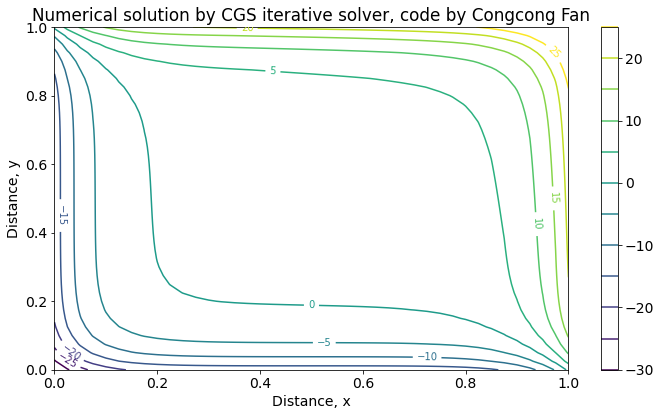

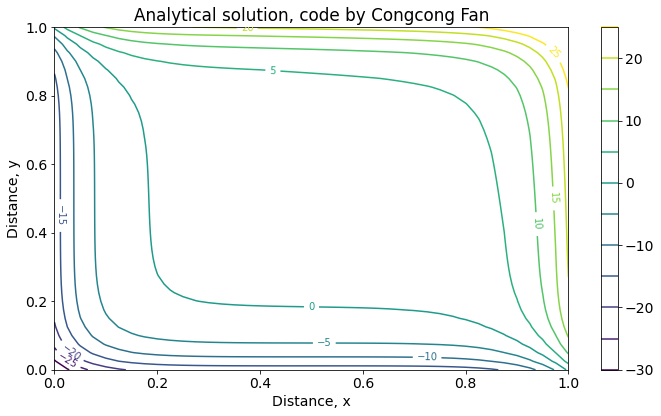

In [16]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx,Ny, 'CGS', convert=True)